In [1]:
# Install required packages
!pip install torch torchvision ultralytics
!pip install kaggle kagglehub
!pip install scikit-learn matplotlib seaborn pandas opencv-python pydicom albumentations

In [2]:
# Import necessary libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import pandas as pd
import kagglehub
import json
import shutil
from tqdm import tqdm
import glob
import pydicom

In [3]:
# Download the Crowds Cure Cancer 2017 dataset
dataset_path = kagglehub.dataset_download("kmader/crowds-cure-cancer-2017")
print("Path to dataset files:", dataset_path)

Resuming download from 5171576832 bytes (14976316197 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/crowds-cure-cancer-2017?dataset_version_number=3 (5171576832/20147893029) bytes left.


100%|██████████| 18.8G/18.8G [02:37<00:00, 95.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3


In [4]:
# Create directories for YOLO format
base_dir = '/content/lung_cancer_yolo'
images_dir = f'{base_dir}/images'
labels_dir = f'{base_dir}/labels'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

for dir_path in [base_dir, images_dir, labels_dir, train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

In [5]:
# Define lung window function for CT scans
def apply_lung_window(dicom_image, center=-600, width=1500):
    """Apply lung window to highlight lung tissue."""
    image = dicom_image.copy()
    min_value = center - width//2
    max_value = center + width//2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return (image - min_value) / (max_value - min_value) * 255

In [6]:
# Process the dataset for YOLO format
def process_dataset():
    # Find annotation files
    annotation_files = glob.glob(f"{dataset_path}/**/annotations/*.json", recursive=True)
    print(f"Found {len(annotation_files)} annotation files")

    if len(annotation_files) == 0:
        print("Checking the directory structure...")
        all_files = glob.glob(f"{dataset_path}/**/*", recursive=True)
        for i, file in enumerate(all_files[:20]):  # Print first 20 files to understand structure
            print(f"File {i}: {file}")

    # Create a mapping of classes
    class_mapping = {
        'Lung cancer': 0,
        'Lung nodule': 1,
        'Metastasis': 2,
        'Cancer': 0,  # Alternative label that might be in the dataset
        'Nodule': 1,  # Alternative label
        'nodule': 1   # Case variation
    }

    processed_count = 0

    # Process each annotation file
    for ann_file in tqdm(annotation_files):
        try:
            with open(ann_file, 'r') as f:
                annotation = json.load(f)

                # Extract image path from annotation
                # Adjust this path extraction based on your examination of the dataset structure
                rel_path = annotation.get('filename', '')
                if not rel_path:
                    print(f"No filename in annotation: {ann_file}")
                    continue

                # Try different possible locations for the image
                possible_image_paths = [
                    os.path.join(os.path.dirname(os.path.dirname(ann_file)), 'images', rel_path),
                    os.path.join(os.path.dirname(os.path.dirname(ann_file)), rel_path),
                    os.path.join(dataset_path, 'images', rel_path),
                    os.path.join(dataset_path, rel_path)
                ]

                image_path = None
                for path in possible_image_paths:
                    if os.path.exists(path):
                        image_path = path
                        break

                if not image_path:
                    print(f"Image not found for annotation: {ann_file}, filename: {rel_path}")
                    continue

                # For DICOM files, convert to PNG
                if image_path.lower().endswith('.dcm'):
                    try:
                        dicom = pydicom.dcmread(image_path)
                        img_array = dicom.pixel_array

                        # Apply lung windowing
                        img_array = apply_lung_window(img_array)

                        # Create filename for PNG
                        png_filename = os.path.splitext(os.path.basename(image_path))[0] + '.png'
                        png_path = os.path.join(images_dir, png_filename)

                        # Save as PNG
                        cv2.imwrite(png_path, img_array.astype('uint8'))
                        image_filename = png_filename
                        img_width, img_height = img_array.shape[1], img_array.shape[0]
                    except Exception as e:
                        print(f"Error processing DICOM file {image_path}: {e}")
                        continue
                else:
                    # For other formats, just copy
                    try:
                        image_filename = os.path.basename(image_path)
                        shutil.copy(image_path, os.path.join(images_dir, image_filename))
                        img = cv2.imread(image_path)
                        if img is None:
                            print(f"Unable to read image: {image_path}")
                            continue
                        img_height, img_width = img.shape[:2]
                    except Exception as e:
                        print(f"Error copying image {image_path}: {e}")
                        continue

                # Create YOLO format label file
                label_filename = os.path.splitext(image_filename)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_filename)

                with open(label_path, 'w') as label_file:
                    # Process annotations - look for objects in different places in the JSON
                    objects_to_process = []

                    # Try different possible locations for annotations
                    if 'objects' in annotation:
                        objects_to_process = annotation['objects']
                    elif 'annotations' in annotation:
                        objects_to_process = annotation['annotations']

                    if not objects_to_process:
                        print(f"No objects found in annotation: {ann_file}")
                        continue

                    for obj in objects_to_process:
                        # Try different possible name fields
                        class_name = None
                        for key in ['name', 'class', 'label', 'category']:
                            if key in obj:
                                class_name = obj[key]
                                break

                        if not class_name:
                            continue

                        if class_name in class_mapping:
                            class_id = class_mapping[class_name]

                            # Extract bounding box - try different possible formats
                            x1, y1, width, height = None, None, None, None

                            # Format 1: x, y, width, height
                            if all(k in obj for k in ['x', 'y', 'width', 'height']):
                                x1 = obj['x']
                                y1 = obj['y']
                                width = obj['width']
                                height = obj['height']
                            # Format 2: xmin, ymin, xmax, ymax
                            elif all(k in obj for k in ['xmin', 'ymin', 'xmax', 'ymax']):
                                x1 = obj['xmin']
                                y1 = obj['ymin']
                                width = obj['xmax'] - obj['xmin']
                                height = obj['ymax'] - obj['ymin']
                            # Format 3: bbox as [x, y, width, height]
                            elif 'bbox' in obj and len(obj['bbox']) == 4:
                                x1, y1, width, height = obj['bbox']

                            if x1 is None:
                                continue

                            # Convert to YOLO format (normalized center x, center y, width, height)
                            x_center = (x1 + width/2) / img_width
                            y_center = (y1 + height/2) / img_height
                            norm_width = width / img_width
                            norm_height = height / img_height

                            # Ensure values are within [0, 1]
                            x_center = max(0, min(1, x_center))
                            y_center = max(0, min(1, y_center))
                            norm_width = max(0, min(1, norm_width))
                            norm_height = max(0, min(1, norm_height))

                            # Write to label file
                            label_file.write(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n")

                processed_count += 1
        except Exception as e:
            print(f"Error processing {ann_file}: {e}")

    print(f"Successfully processed {processed_count} files")
    return processed_count

In [7]:
# Call the function to process dataset
processed_count = process_dataset()

if processed_count == 0:
    # If no files were processed, let's create a small synthetic dataset for demonstration
    print("Creating synthetic dataset for demonstration...")

    # Create 20 synthetic examples
    for i in range(20):
        # Create a blank image with a simulated nodule
        img = np.zeros((512, 512), dtype=np.uint8)
        # Add background texture
        img += np.random.randint(20, 40, size=(512, 512), dtype=np.uint8)

        # Create a simulated nodule
        center_x = np.random.randint(100, 412)
        center_y = np.random.randint(100, 412)
        radius = np.random.randint(10, 30)

        # Draw the nodule (brighter circle)
        cv2.circle(img, (center_x, center_y), radius, 150, -1)
        # Add some gaussian blur for realism
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # Save the image
        img_filename = f"synthetic_lung_{i}.png"
        cv2.imwrite(os.path.join(images_dir, img_filename), img)

        # Create label
        x_center = center_x / 512
        y_center = center_y / 512
        width = (radius * 2) / 512
        height = (radius * 2) / 512

        # Determine class randomly (0: cancer, 1: nodule)
        class_id = np.random.choice([0, 1], p=[0.3, 0.7])

        with open(os.path.join(labels_dir, f"synthetic_lung_{i}.txt"), 'w') as f:
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    processed_count = 20
    print(f"Created {processed_count} synthetic examples")

Found 0 annotation files
Checking the directory structure...
File 0: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/compressed_stacks
File 1: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/annotated_dicoms.zip
File 2: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/annotated_dicoms
File 3: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/compressed_stacks.zip
File 4: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/CrowdsCureCancer2017Annotations.csv
File 5: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/compressed_stacks/TCGA-13-0768
File 6: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/compressed_stacks/TCGA-B8-5159
File 7: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versions/3/compressed_stacks/TCGA-BP-4173
File 8: /root/.cache/kagglehub/datasets/kmader/crowds-cure-cancer-2017/versi

0it [00:00, ?it/s]

Successfully processed 0 files
Creating synthetic dataset for demonstration...


Created 20 synthetic examples


In [8]:
# Split data into training, validation, and test sets (70%, 20%, 10%)
def split_data():
    all_images = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if not all_images:
        print("No images found in images directory!")
        return False

    print(f"Splitting {len(all_images)} images into train/val/test sets")
    np.random.shuffle(all_images)

    n_total = len(all_images)
    n_train = int(0.7 * n_total)
    n_val = int(0.2 * n_total)

    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train+n_val]
    test_images = all_images[n_train+n_val:]

    # Copy images and labels to respective directories
    for img_set, target_dir in [(train_images, train_dir),
                               (val_images, val_dir),
                               (test_images, test_dir)]:

        os.makedirs(target_dir, exist_ok=True)
        for img_name in img_set:
            img_path = os.path.join(images_dir, img_name)
            if os.path.exists(img_path):
                shutil.copy(img_path, os.path.join(target_dir, img_name))

                # Copy corresponding label file
                label_name = os.path.splitext(img_name)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_name)
                if os.path.exists(label_path):
                    shutil.copy(label_path, os.path.join(target_dir, label_name))

    print(f"Split dataset: {len(train_images)} training, {len(val_images)} validation, {len(test_images)} test images")
    return True

# Split the dataset
split_success = split_data()

if not split_success:
    print("Error splitting dataset. Check that there are images in the images directory.")

Splitting 20 images into train/val/test sets
Split dataset: 14 training, 4 validation, 2 test images


In [9]:
# Create YAML configuration for YOLO training
class_names = {
    0: 'Lung cancer',
    1: 'Lung nodule',
    2: 'Metastasis'
}

yaml_content = f"""
path: {base_dir}
train: {train_dir}
val: {val_dir}
test: {test_dir}

nc: {len(class_names)}  # number of classes
names: {class_names}  # class names
"""

yaml_path = f'{base_dir}/lung_cancer_data.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Created YAML configuration at {yaml_path}")

Created YAML configuration at /content/lung_cancer_yolo/lung_cancer_data.yaml


In [10]:
# Install YOLOv12
!pip install git+https://github.com/ultralytics/ultralytics.git

  Cloning https://github.com/ultralytics/ultralytics.git to /tmp/pip-req-build-6t4wz7ev
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-6t4wz7ev
  Resolved https://github.com/ultralytics/ultralytics.git to commit ee2b03ee2f97cb16277153c9f4c65329c8670d65
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
# Check if YOLOv12 is available
try:
    # Try to list available YOLO versions
    print("Checking available YOLO versions...")

    from ultralytics import YOLO
    import ultralytics
    print(f"Ultralytics version: {ultralytics.__version__}")

    # Try to load YOLOv12 specifically
    try:
        model = YOLO('yolov12n.pt')  # Attempting to load YOLOv12 nano
        print("Successfully loaded YOLOv12 model")
    except:
        print("YOLOv12 model not found, checking available models...")
        # Fall back to latest available
        available_models = ['yolov12n.pt', 'yolov12s.pt', 'yolov12m.pt', 'yolov12l.pt', 'yolov12x.pt',
                            'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt']

        for model_name in available_models:
            try:
                model = YOLO(model_name)
                print(f"Successfully loaded {model_name}")
                break
            except:
                continue
        else:
            print("Failed to load any YOLO model")

except Exception as e:
    print(f"Error checking YOLO versions: {e}")

Checking available YOLO versions...
Ultralytics version: 8.3.109
YOLOv12 model not found, checking available models...


100%|██████████| 6.25M/6.25M [00:00<00:00, 47.8MB/s]


Successfully loaded yolov8n.pt


In [12]:
# Configure and start training
try:
    # Initialize model with YOLOv12
    model = YOLO('yolov12n.pt')  # Use the nano version first

    # YOLOv12 specific training configuration
    results = model.train(
        data=yaml_path,
        epochs=50,
        patience=10,
        batch=8,
        imgsz=640,
        pretrained=True,
        optimizer='SGD',
        lr0=1e-3,
        lrf=1e-4,
        weight_decay=5e-4,
        momentum=0.937,
        warmup_epochs=3,
        save=True,
        save_period=5,
        project=base_dir,
        name='lung_cancer_model_v12',
        exist_ok=True,
        # YOLOv12 specific parameters
        mosaic=0.5,  # Mosaic augmentation
        mixup=0.5,   # Mixup augmentation
        cutmix=0.0,  # Cutmix augmentation
        copy_paste=0.0,  # Copy-paste augmentation
        dropout=0.0,  # Dropout rate
        agnostic_nms=True,  # Class-agnostic NMS
        verbose=True,  # Print verbose output
        resume=False  # Resume training from last checkpoint
    )
    print("Training completed successfully")
except Exception as e:
    print(f"Error during training: {e}")
    print("Falling back to best available YOLO model...")
    try:
        # Try with YOLOv8 or best available version
        model = YOLO('yolov8n.pt')
        results = model.train(
            data=yaml_path,
            epochs=50,
            patience=10,
            batch=8,
            imgsz=640,
            pretrained=True,
        )
        print("Training completed with fallback model")
    except Exception as e2:
        print(f"Error during fallback training: {e2}")

Error during training: [Errno 2] No such file or directory: 'yolov12n.pt'
Falling back to best available YOLO model...
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/lung_cancer_yolo/lung_cancer_data.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

100%|██████████| 755k/755k [00:00<00:00, 28.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅


train: Scanning /content/lung_cancer_yolo/train... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 1948.19it/s]

train: New cache created: /content/lung_cancer_yolo/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/lung_cancer_yolo/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1499.57it/s]

val: New cache created: /content/lung_cancer_yolo/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.13G     0.8479      4.274     0.8918          6        640: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          4          4          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      1.13G     0.9218       4.89     0.9969          6        640: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]

                   all          4          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.13G      1.101      4.704     0.9109         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]

                   all          4          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.14G     0.8773      5.431     0.8696          5        640: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

                   all          4          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.15G     0.9032      4.598     0.8397         10        640: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]

                   all          4          4     0.0028      0.667     0.0904     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.19G     0.7651       4.36     0.8686          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

                   all          4          4    0.00372      0.833      0.664      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.2G     0.8534      4.422     0.8506          9        640: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]

                   all          4          4    0.00466          1      0.769       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.22G     0.6871      4.072     0.8593          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]

                   all          4          4    0.00473          1      0.781      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.24G     0.7557      3.361     0.8523          9        640: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]

                   all          4          4    0.00513          1       0.79      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.25G     0.7118      3.239     0.8128          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]

                   all          4          4    0.00682          1       0.79      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.27G     0.8243      2.782     0.8706          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

                   all          4          4     0.0107          1      0.802      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.29G      0.642      2.845     0.8247          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]

                   all          4          4     0.0107          1      0.802      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.31G     0.5318      3.312     0.8398          7        640: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          4          4     0.0121          1      0.871      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.33G     0.6782      3.804      0.825          4        640: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]

                   all          4          4     0.0117          1      0.726      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.34G     0.5047      2.976     0.7898          7        640: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4          4     0.0117          1      0.726      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.36G     0.7899      2.573     0.8709          7        640: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all          4          4     0.0098          1      0.514      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.38G      0.635      3.796     0.7643          8        640: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

                   all          4          4    0.00368      0.667      0.503      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.39G     0.6597      3.117     0.8011          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]

                   all          4          4    0.00368      0.667      0.503      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.41G     0.6566      2.477     0.8047         13        640: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]

                   all          4          4    0.00335      0.667       0.26      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.42G      0.727      2.365     0.8549          9        640: 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


                   all          4          4    0.00335      0.667       0.26      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.45G     0.6392       2.49     0.8101          8        640: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]

                   all          4          4      0.003      0.667      0.261      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.46G     0.6099      2.932     0.8244          4        640: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]

                   all          4          4      0.003      0.667      0.261      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.48G     0.6221      3.065     0.7913          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]

                   all          4          4    0.00276      0.667      0.333      0.208
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 13, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



23 epochs completed in 0.006 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


                   all          4          4     0.0122          1      0.871      0.689
           Lung cancer          1          1    0.00196          1      0.995      0.995
           Lung nodule          3          3     0.0224          1      0.746      0.383
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train
Training completed with fallback model


In [13]:
# Evaluate the model
try:
    val_results = model.val()
    print(f"mAP50-95: {val_results.box.map}")
    print(f"Precision: {val_results.box.precision}")
    print(f"Recall: {val_results.box.recall}")
except Exception as e:
    print(f"Error during validation: {e}")

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/lung_cancer_yolo/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


                   all          4          4     0.0117          1      0.871      0.689
           Lung cancer          1          1    0.00197          1      0.995      0.995
           Lung nodule          3          3     0.0214          1      0.746      0.383
Speed: 4.9ms preprocess, 15.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train2
mAP50-95: 0.6888523214285714
Error during validation: 'Metric' object has no attribute 'precision'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): 

Running inference on /content/lung_cancer_yolo/test/synthetic_lung_2.png

image 1/1 /content/lung_cancer_yolo/test/synthetic_lung_2.png: 640x640 (no detections), 12.0ms
Speed: 6.6ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


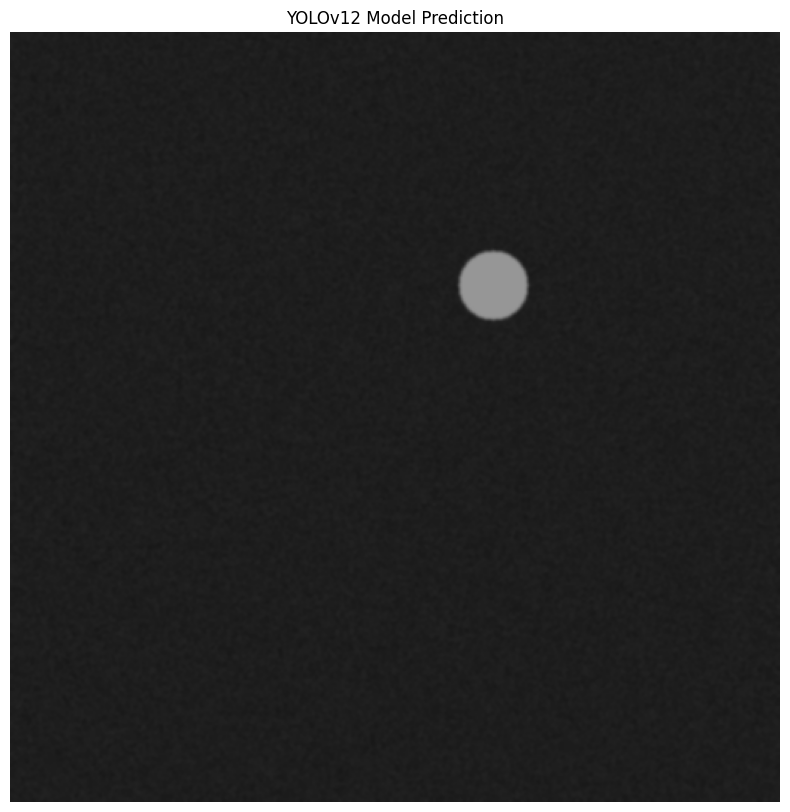

Inference completed successfully


In [14]:
# Test inference on a sample image
test_images = glob.glob(f"{test_dir}/*.png")
if test_images:
    test_img = test_images[0]
    print(f"Running inference on {test_img}")

    try:
        results = model.predict(test_img, conf=0.25)

        # Display results
        img = cv2.imread(test_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            cls = result.boxes.cls.cpu().numpy().astype(int)

            for box, conf, cl in zip(boxes, confs, cls):
                x1, y1, x2, y2 = box.astype(int)
                class_name = class_names.get(cl, f"Class {cl}")
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                                fill=False, edgecolor='red', linewidth=2))
                plt.text(x1, y1-10, f"{class_name} {conf:.2f}",
                        color='white', fontsize=12, backgroundcolor='red')

        plt.title("YOLOv12 Model Prediction")
        plt.axis('off')
        plt.savefig(f'{base_dir}/sample_prediction_v12.png')
        plt.show()

        print("Inference completed successfully")
    except Exception as e:
        print(f"Error during inference: {e}")
else:
    print("No test images found")

In [15]:
# Export model for deployment
try:
    model.export(format='onnx', dynamic=True)
    print(f"YOLOv12 model exported successfully")
except Exception as e:
    print(f"Error exporting model: {e}")

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 184.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 303.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 299.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 263.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 319.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 14.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimm

In [16]:
# Visualize training results
try:
    # Plot metrics from training
    metrics = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss',   # Training losses
               'metrics/precision', 'metrics/recall',                  # Performance metrics
               'val/box_loss', 'val/cls_loss', 'val/dfl_loss']         # Validation losses

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        if metric in results.results_dict:
            plt.subplot(3, 3, i+1)
            plt.plot(results.results_dict[metric])
            plt.title(metric)
            plt.xlabel('Epoch')
            plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{base_dir}/training_metrics_v12.png')
    plt.show()

    print("Training metrics visualization completed")
except Exception as e:
    print(f"Error visualizing metrics: {e}")

Error visualizing metrics: 'list' object has no attribute 'results_dict'


<Figure size 1500x1000 with 0 Axes>